In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

keras = tf.keras

# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 10]

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    

def sequential_window_dataset(series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

In [23]:
# Read in data
spy = pd.read_excel(r"C:\Users\Muthumanimaran\Downloads\TCS\TCSQC\FTSE100\Forecasting.xlsx"  
                    ,sheet_name='^FTSE')

# Convert series into datetime type
spy['Date'] = pd.to_datetime(spy['Date'])

# Save target series
series = spy['Close']

# Create train data set
train_split_date = '2015-12-31'
train_split_index = np.where(spy.Date == train_split_date)[0][0]
x_train = spy.loc[spy['Date'] <= train_split_date]['Close']

# Create test data set
test_split_date = '2020-01-02'
test_split_index = np.where(spy.Date == test_split_date)[0][0]
x_test = spy.loc[spy['Date'] >= test_split_date]['Close']

# Create valid data set
valid_split_index = (train_split_index.max(),test_split_index.min())
x_valid = spy.loc[(spy['Date'] < test_split_date) & (spy['Date'] > train_split_date)]['Close']

1130 1131 2174 2175 3138


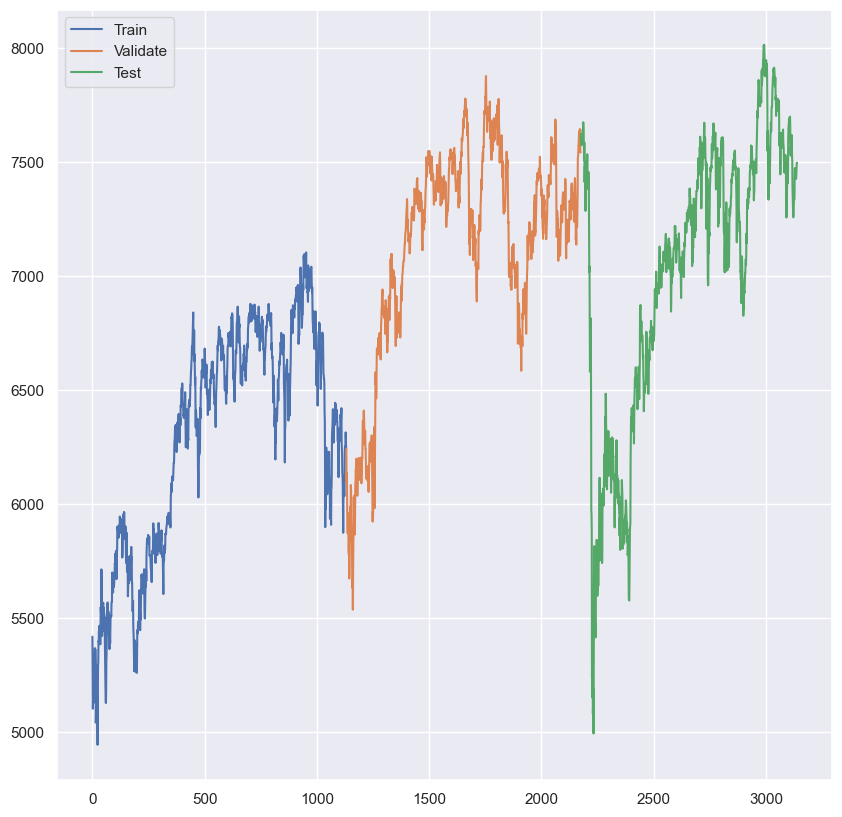

In [24]:
# Plot all lines on one chart to see where one segment starts and another ends
plt.plot(x_train, label = 'Train')
plt.plot(x_valid, label = 'Validate')
plt.plot(x_test, label = 'Test')
plt.legend()
print(x_train.index.max(),x_valid.index.min(),x_valid.index.max(),x_test.index.min(),x_test.index.max())

In [25]:
# Reshape values
x_train_values = x_train.values.reshape(-1, 1)
x_valid_values = x_valid.values.reshape(-1, 1)
x_test_values = x_test.values.reshape(-1, 1)

#  Create Scaler Object
x_train_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit x_train values
normalized_x_train = x_train_scaler.fit_transform(x_train_values)

# Fit x_valid values
normalized_x_valid = x_train_scaler.transform(x_valid_values)

# Fit x_test values
normalized_x_test = x_train_scaler.transform(x_test_values)

# All values normalized to training data
spy_normalized_to_traindata = x_train_scaler.transform(series.values.reshape(-1, 1))

# Example of how to iverse
# inversed = scaler.inverse_transform(normalized_x_train).flatten()

In [26]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

## Find the learning Rate

In [27]:
# reset any stored data
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Set window size and create input batch sequences
window_size = 20
train_set = sequential_window_dataset(normalized_x_train, window_size)

# create model
model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
])

# create lr
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))
reset_states = ResetStatesCallback()

# choose optimizer
optimizer = keras.optimizers.Nadam(lr=1e-5)

# compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# set history
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/100
56/56 [==============================] - 6s 19ms/step - loss: 0.2011 - mae: 0.5993 - lr: 1.0000e-05
Epoch 2/100
56/56 [==============================] - 1s 16ms/step - loss: 0.1438 - mae: 0.5044 - lr: 1.1220e-05
Epoch 3/100
56/56 [==============================] - 1s 16ms/step - loss: 0.0893 - mae: 0.3958 - lr: 1.2589e-05
Epoch 4/100
56/56 [==============================] - 1s 17ms/step - loss: 0.0380 - mae: 0.2545 - lr: 1.4125e-05
Epoch 5/100
56/56 [==============================] - 1s 16ms/step - loss: 0.0070 - mae: 0.1030 - lr: 1.5849e-05
Epoch 6/100
56/56 [==============================] - 1s 15ms/step - loss: 0.0023 - mae: 0.0527 - lr: 1.7783e-05
Epoch 7/100
56/56 [==============================] - 1s 13ms/step - loss: 0.0023 - mae: 0.0527 - lr: 1.9953e-05
Epoch 8/100
56/56 [==============================] - 1s 11ms/step - loss: 0.0023 - mae: 0.0528 - lr: 2.2387e-05
Epoch 9/100
56/56 [==============================] - 1s 11ms/step - loss: 0.0023 - mae: 0.0528 - lr: 2.5

56/56 [==============================] - 1s 14ms/step - loss: 0.0208 - mae: 0.1585 - lr: 0.0447
Epoch 75/100
56/56 [==============================] - 1s 14ms/step - loss: 0.0238 - mae: 0.1605 - lr: 0.0501
Epoch 76/100
56/56 [==============================] - 1s 15ms/step - loss: 0.0102 - mae: 0.1042 - lr: 0.0562
Epoch 77/100
56/56 [==============================] - 1s 16ms/step - loss: 0.0098 - mae: 0.1068 - lr: 0.0631
Epoch 78/100
56/56 [==============================] - 1s 16ms/step - loss: 0.0101 - mae: 0.1077 - lr: 0.0708
Epoch 79/100
56/56 [==============================] - 1s 15ms/step - loss: 0.0080 - mae: 0.0956 - lr: 0.0794
Epoch 80/100
56/56 [==============================] - 1s 16ms/step - loss: 0.0076 - mae: 0.0912 - lr: 0.0891
Epoch 81/100
56/56 [==============================] - 1s 15ms/step - loss: 0.0117 - mae: 0.1081 - lr: 0.1000
Epoch 82/100
56/56 [==============================] - 1s 15ms/step - loss: 0.0182 - mae: 0.1186 - lr: 0.1122
Epoch 83/100
56/56 [============

(1e-08, 1.0, 0.0, 0.01)

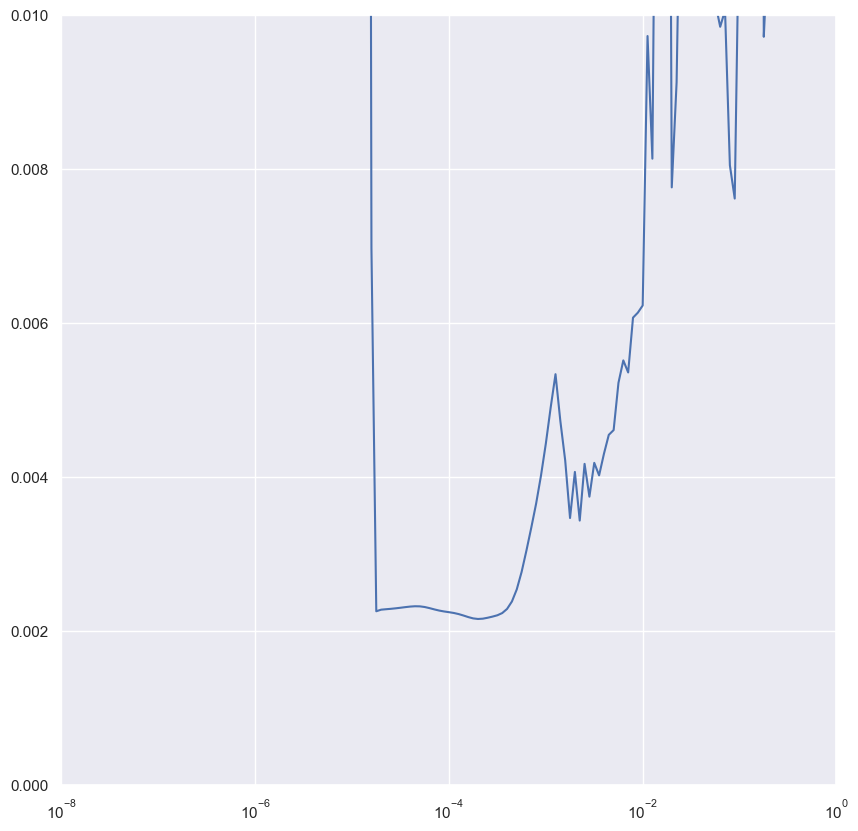

In [28]:
# Plot the learning rate chart
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1, 0, 0.01])

## Build and Train LSTM Model

In [29]:
# reset any stored data
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# set window size and create input batch sequence
window_size = 30
train_set = sequential_window_dataset(normalized_x_train, window_size)
valid_set = sequential_window_dataset(normalized_x_valid, window_size)

# create model
model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
])

# set optimizer
optimizer = keras.optimizers.Nadam(lr=1e-4)

# compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# reset states
reset_states = ResetStatesCallback()

#set up save best only checkpoint
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)

early_stopping = keras.callbacks.EarlyStopping(patience=50)

# fit model
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
     37/Unknown - 5s 14ms/step - loss: 0.0053 - mae: 0.0783INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 10s 167ms/step - loss: 0.0053 - mae: 0.0783 - val_loss: 0.0137 - val_mae: 0.1510
Epoch 2/500
37/37 [==============================] - 1s 20ms/step - loss: 0.0020 - mae: 0.0494 - val_loss: 0.0213 - val_mae: 0.1907
Epoch 3/500
37/37 [==============================] - 1s 20ms/step - loss: 0.0020 - mae: 0.0504 - val_loss: 0.0266 - val_mae: 0.2134
Epoch 4/500
37/37 [==============================] - 1s 20ms/step - loss: 0.0023 - mae: 0.0539 - val_loss: 0.0292 - val_mae: 0.2229
Epoch 5/500
37/37 [==============================] - 1s 20ms/step - loss: 0.0028 - mae: 0.0593 - val_loss: 0.0303 - val_mae: 0.2265
Epoch 6/500
37/37 [==============================] - 1s 21ms/step - loss: 0.0030 - mae: 0.0617 - val_loss: 0.0334 - val_mae: 0.2377
Epoch 7/500
37/37 [==============================] - 1s 20ms/step - loss: 0.0030 - mae: 0.0622 - val_loss: 0.0278 - val_mae: 0.2154
Epoch 8/500
37/37 [==============================] - 1s 20ms/step - loss: 0.0041 - mae

INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 178ms/step - loss: 0.0031 - mae: 0.0633 - val_loss: 0.0136 - val_mae: 0.1481
Epoch 17/500
36/37 [============================>.] - ETA: 0s - loss: 0.0024 - mae: 0.0556INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 5s 152ms/step - loss: 0.0024 - mae: 0.0553 - val_loss: 0.0122 - val_mae: 0.1395
Epoch 18/500
37/37 [==============================] - ETA: 0s - loss: 0.0018 - mae: 0.0473INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 167ms/step - loss: 0.0018 - mae: 0.0473 - val_loss: 0.0108 - val_mae: 0.1307
Epoch 19/500
35/37 [===========================>..] - ETA: 0s - loss: 0.0014 - mae: 0.0416INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 169ms/step - loss: 0.0015 - mae: 0.0422 - val_loss: 0.0099 - val_mae: 0.1248
Epoch 20/500
35/37 [===========================>..] - ETA: 0s - loss: 0.0013 - mae: 0.0393INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 156ms/step - loss: 0.0013 - mae: 0.0399 - val_loss: 0.0092 - val_mae: 0.1205
Epoch 21/500
35/37 [===========================>..] - ETA: 0s - loss: 0.0012 - mae: 0.0381INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 158ms/step - loss: 0.0013 - mae: 0.0387 - val_loss: 0.0087 - val_mae: 0.1171
Epoch 22/500
37/37 [==============================] - ETA: 0s - loss: 0.0012 - mae: 0.0379INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 167ms/step - loss: 0.0012 - mae: 0.0379 - val_loss: 0.0083 - val_mae: 0.1143
Epoch 23/500
37/37 [==============================] - ETA: 0s - loss: 0.0012 - mae: 0.0372   INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 161ms/step - loss: 0.0012 - mae: 0.0372 - val_loss: 0.0080 - val_mae: 0.1119
Epoch 24/500
36/37 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0365    INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 5s 147ms/step - loss: 0.0011 - mae: 0.0366 - val_loss: 0.0077 - val_mae: 0.1098
Epoch 25/500
37/37 [==============================] - ETA: 0s - loss: 0.0011 - mae: 0.0361    INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 5s 148ms/step - loss: 0.0011 - mae: 0.0361 - val_loss: 0.0074 - val_mae: 0.1079
Epoch 26/500
37/37 [==============================] - ETA: 0s - loss: 0.0011 - mae: 0.0356    INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 169ms/step - loss: 0.0011 - mae: 0.0356 - val_loss: 0.0072 - val_mae: 0.1063
Epoch 27/500
34/37 [==========================>...] - ETA: 0s - loss: 9.2436e-04 - mae: 0.0335INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 162ms/step - loss: 0.0011 - mae: 0.0352 - val_loss: 0.0070 - val_mae: 0.1048
Epoch 28/500
37/37 [==============================] - ETA: 0s - loss: 0.0010 - mae: 0.0348    INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 5s 149ms/step - loss: 0.0010 - mae: 0.0348 - val_loss: 0.0068 - val_mae: 0.1034
Epoch 29/500
37/37 [==============================] - ETA: 0s - loss: 0.0010 - mae: 0.0345    INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 152ms/step - loss: 0.0010 - mae: 0.0345 - val_loss: 0.0066 - val_mae: 0.1022
Epoch 30/500
37/37 [==============================] - ETA: 0s - loss: 9.9421e-04 - mae: 0.0341INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 165ms/step - loss: 9.9421e-04 - mae: 0.0341 - val_loss: 0.0065 - val_mae: 0.1010
Epoch 31/500
37/37 [==============================] - ETA: 0s - loss: 9.7748e-04 - mae: 0.0338INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 158ms/step - loss: 9.7748e-04 - mae: 0.0338 - val_loss: 0.0063 - val_mae: 0.0999
Epoch 32/500
37/37 [==============================] - ETA: 0s - loss: 9.6174e-04 - mae: 0.0335INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 5s 151ms/step - loss: 9.6174e-04 - mae: 0.0335 - val_loss: 0.0062 - val_mae: 0.0988
Epoch 33/500
37/37 [==============================] - ETA: 0s - loss: 9.4684e-04 - mae: 0.0333INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 5s 148ms/step - loss: 9.4684e-04 - mae: 0.0333 - val_loss: 0.0061 - val_mae: 0.0978
Epoch 34/500
36/37 [============================>.] - ETA: 0s - loss: 9.3154e-04 - mae: 0.0329INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 165ms/step - loss: 9.3268e-04 - mae: 0.0330 - val_loss: 0.0059 - val_mae: 0.0968
Epoch 35/500
37/37 [==============================] - ETA: 0s - loss: 9.1915e-04 - mae: 0.0328INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 162ms/step - loss: 9.1915e-04 - mae: 0.0328 - val_loss: 0.0058 - val_mae: 0.0958
Epoch 36/500
36/37 [============================>.] - ETA: 0s - loss: 9.0502e-04 - mae: 0.0325INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 5s 149ms/step - loss: 9.0618e-04 - mae: 0.0325 - val_loss: 0.0057 - val_mae: 0.0949
Epoch 37/500
35/37 [===========================>..] - ETA: 0s - loss: 8.5821e-04 - mae: 0.0316INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 5s 148ms/step - loss: 8.9374e-04 - mae: 0.0323 - val_loss: 0.0056 - val_mae: 0.0939
Epoch 38/500
36/37 [============================>.] - ETA: 0s - loss: 8.8055e-04 - mae: 0.0320INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 168ms/step - loss: 8.8176e-04 - mae: 0.0321 - val_loss: 0.0055 - val_mae: 0.0930
Epoch 39/500
37/37 [==============================] - ETA: 0s - loss: 8.7023e-04 - mae: 0.0319INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 159ms/step - loss: 8.7023e-04 - mae: 0.0319 - val_loss: 0.0054 - val_mae: 0.0922
Epoch 40/500
37/37 [==============================] - ETA: 0s - loss: 8.5913e-04 - mae: 0.0317INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 5s 146ms/step - loss: 8.5913e-04 - mae: 0.0317 - val_loss: 0.0053 - val_mae: 0.0913
Epoch 41/500
37/37 [==============================] - ETA: 0s - loss: 8.4843e-04 - mae: 0.0315INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 155ms/step - loss: 8.4843e-04 - mae: 0.0315 - val_loss: 0.0052 - val_mae: 0.0905
Epoch 42/500
37/37 [==============================] - ETA: 0s - loss: 8.3811e-04 - mae: 0.0313INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 171ms/step - loss: 8.3811e-04 - mae: 0.0313 - val_loss: 0.0051 - val_mae: 0.0897
Epoch 43/500
37/37 [==============================] - ETA: 0s - loss: 8.2818e-04 - mae: 0.0311INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 161ms/step - loss: 8.2818e-04 - mae: 0.0311 - val_loss: 0.0050 - val_mae: 0.0889
Epoch 44/500
35/37 [===========================>..] - ETA: 0s - loss: 7.8337e-04 - mae: 0.0302INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 162ms/step - loss: 8.1862e-04 - mae: 0.0309 - val_loss: 0.0049 - val_mae: 0.0881
Epoch 45/500
36/37 [============================>.] - ETA: 0s - loss: 8.0784e-04 - mae: 0.0306INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 165ms/step - loss: 8.0942e-04 - mae: 0.0307 - val_loss: 0.0048 - val_mae: 0.0874
Epoch 46/500
35/37 [===========================>..] - ETA: 0s - loss: 7.6525e-04 - mae: 0.0298INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 178ms/step - loss: 8.0057e-04 - mae: 0.0306 - val_loss: 0.0047 - val_mae: 0.0866
Epoch 47/500
37/37 [==============================] - ETA: 0s - loss: 7.9207e-04 - mae: 0.0304INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 176ms/step - loss: 7.9207e-04 - mae: 0.0304 - val_loss: 0.0046 - val_mae: 0.0859
Epoch 48/500
35/37 [===========================>..] - ETA: 0s - loss: 7.4844e-04 - mae: 0.0295INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 156ms/step - loss: 7.8391e-04 - mae: 0.0302 - val_loss: 0.0046 - val_mae: 0.0853
Epoch 49/500
37/37 [==============================] - ETA: 0s - loss: 7.7608e-04 - mae: 0.0301INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 164ms/step - loss: 7.7608e-04 - mae: 0.0301 - val_loss: 0.0045 - val_mae: 0.0846
Epoch 50/500
35/37 [===========================>..] - ETA: 0s - loss: 7.3288e-04 - mae: 0.0292INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 173ms/step - loss: 7.6856e-04 - mae: 0.0299 - val_loss: 0.0044 - val_mae: 0.0840
Epoch 51/500
37/37 [==============================] - ETA: 0s - loss: 7.6135e-04 - mae: 0.0298INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 164ms/step - loss: 7.6135e-04 - mae: 0.0298 - val_loss: 0.0043 - val_mae: 0.0834
Epoch 52/500
35/37 [===========================>..] - ETA: 0s - loss: 7.1850e-04 - mae: 0.0289INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 5s 148ms/step - loss: 7.5443e-04 - mae: 0.0297 - val_loss: 0.0043 - val_mae: 0.0829
Epoch 53/500
37/37 [==============================] - ETA: 0s - loss: 7.4779e-04 - mae: 0.0295INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 5s 147ms/step - loss: 7.4779e-04 - mae: 0.0295 - val_loss: 0.0042 - val_mae: 0.0824
Epoch 54/500
37/37 [==============================] - ETA: 0s - loss: 7.4141e-04 - mae: 0.0294INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 8s 219ms/step - loss: 7.4141e-04 - mae: 0.0294 - val_loss: 0.0042 - val_mae: 0.0819
Epoch 55/500
36/37 [============================>.] - ETA: 0s - loss: 7.3287e-04 - mae: 0.0292INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 7s 185ms/step - loss: 7.3529e-04 - mae: 0.0293 - val_loss: 0.0041 - val_mae: 0.0814
Epoch 56/500
37/37 [==============================] - ETA: 0s - loss: 7.2942e-04 - mae: 0.0292INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 7s 189ms/step - loss: 7.2942e-04 - mae: 0.0292 - val_loss: 0.0041 - val_mae: 0.0809
Epoch 57/500
37/37 [==============================] - ETA: 0s - loss: 7.2379e-04 - mae: 0.0291INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 171ms/step - loss: 7.2379e-04 - mae: 0.0291 - val_loss: 0.0040 - val_mae: 0.0805
Epoch 58/500
35/37 [===========================>..] - ETA: 0s - loss: 6.8162e-04 - mae: 0.0282INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 7s 188ms/step - loss: 7.1840e-04 - mae: 0.0290 - val_loss: 0.0040 - val_mae: 0.0801
Epoch 59/500
37/37 [==============================] - ETA: 0s - loss: 7.1325e-04 - mae: 0.0289INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 7s 181ms/step - loss: 7.1325e-04 - mae: 0.0289 - val_loss: 0.0039 - val_mae: 0.0797
Epoch 60/500
35/37 [===========================>..] - ETA: 0s - loss: 6.7125e-04 - mae: 0.0280INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 162ms/step - loss: 7.0837e-04 - mae: 0.0288 - val_loss: 0.0039 - val_mae: 0.0793
Epoch 61/500
36/37 [============================>.] - ETA: 0s - loss: 7.0075e-04 - mae: 0.0286INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 168ms/step - loss: 7.0371e-04 - mae: 0.0287 - val_loss: 0.0039 - val_mae: 0.0789
Epoch 62/500
37/37 [==============================] - ETA: 0s - loss: 6.9940e-04 - mae: 0.0286INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 7s 187ms/step - loss: 6.9940e-04 - mae: 0.0286 - val_loss: 0.0038 - val_mae: 0.0786
Epoch 63/500
37/37 [==============================] - ETA: 0s - loss: 6.9518e-04 - mae: 0.0285INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 7s 180ms/step - loss: 6.9518e-04 - mae: 0.0285 - val_loss: 0.0038 - val_mae: 0.0782
Epoch 64/500
36/37 [============================>.] - ETA: 0s - loss: 6.8849e-04 - mae: 0.0283INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 164ms/step - loss: 6.9173e-04 - mae: 0.0285 - val_loss: 0.0038 - val_mae: 0.0780
Epoch 65/500
37/37 [==============================] - ETA: 0s - loss: 6.8726e-04 - mae: 0.0284INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 175ms/step - loss: 6.8726e-04 - mae: 0.0284 - val_loss: 0.0037 - val_mae: 0.0775
Epoch 66/500
37/37 [==============================] - 1s 26ms/step - loss: 6.8657e-04 - mae: 0.0284 - val_loss: 0.0038 - val_mae: 0.0781
Epoch 67/500
36/37 [============================>.] - ETA: 0s - loss: 6.7099e-04 - mae: 0.0280INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 7s 192ms/step - loss: 6.7458e-04 - mae: 0.0281 - val_loss: 0.0036 - val_mae: 0.0765
Epoch 68/500
37/37 [==============================] - 1s 25ms/step - loss: 6.7903e-04 - mae: 0.0282 - val_loss: 0.0047 - val_mae: 0.0878
Epoch 69/500
37/37 [==============================] - 1s 25ms/step - loss: 6.2929e-04 - mae: 0.0267 - val_loss: 0.0040 - val_mae: 0.0807
Epoch 70/500
37/37 [==============================] - 1s 24ms/step - loss: 7.4070e-04 - mae: 0.0296 - val_loss: 0.0044 - val_mae: 0.0848
Epoch 71/500
37/37 [==============================] - 1s 25ms/step - loss: 6.7051e-04 - mae: 0.0280 - val_loss: 0.0042 - val_mae: 0.0825
Epoch 72/500
37/37 [==============================] - 1s 24ms/step - loss: 7.6461e-04 - mae: 0.0302 - val_loss: 0.0038 - val_mae: 0.0786
Epoch 73/500
37/37 [==============================] - 1s 25ms/step - loss: 6.8076e-04 - mae: 0.0283 - val_loss: 0.0039 - val_mae: 0.0790
Epoch 74/500
37/37 [==============================] -

INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 177ms/step - loss: 6.6414e-04 - mae: 0.0280 - val_loss: 0.0035 - val_mae: 0.0751
Epoch 77/500
37/37 [==============================] - 1s 23ms/step - loss: 6.8791e-04 - mae: 0.0286 - val_loss: 0.0035 - val_mae: 0.0757
Epoch 78/500
34/37 [==========================>...] - ETA: 0s - loss: 5.7058e-04 - mae: 0.0264INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 162ms/step - loss: 6.6426e-04 - mae: 0.0280 - val_loss: 0.0034 - val_mae: 0.0741
Epoch 79/500
37/37 [==============================] - 1s 23ms/step - loss: 6.8718e-04 - mae: 0.0286 - val_loss: 0.0034 - val_mae: 0.0742
Epoch 80/500
35/37 [===========================>..] - ETA: 0s - loss: 6.3594e-04 - mae: 0.0275INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 168ms/step - loss: 6.7952e-04 - mae: 0.0284 - val_loss: 0.0033 - val_mae: 0.0734
Epoch 81/500
36/37 [============================>.] - ETA: 0s - loss: 6.8296e-04 - mae: 0.0285INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 7s 182ms/step - loss: 6.8648e-04 - mae: 0.0286 - val_loss: 0.0033 - val_mae: 0.0728
Epoch 82/500
35/37 [===========================>..] - ETA: 0s - loss: 6.2920e-04 - mae: 0.0274INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 172ms/step - loss: 6.7301e-04 - mae: 0.0283 - val_loss: 0.0032 - val_mae: 0.0725
Epoch 83/500
35/37 [===========================>..] - ETA: 0s - loss: 6.4646e-04 - mae: 0.0278INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 154ms/step - loss: 6.8770e-04 - mae: 0.0286 - val_loss: 0.0032 - val_mae: 0.0719
Epoch 84/500
37/37 [==============================] - ETA: 0s - loss: 6.5664e-04 - mae: 0.0279INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 154ms/step - loss: 6.5664e-04 - mae: 0.0279 - val_loss: 0.0032 - val_mae: 0.0717
Epoch 85/500
37/37 [==============================] - 1s 22ms/step - loss: 7.0168e-04 - mae: 0.0289 - val_loss: 0.0032 - val_mae: 0.0719
Epoch 86/500
36/37 [============================>.] - ETA: 0s - loss: 6.3830e-04 - mae: 0.0274INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 177ms/step - loss: 6.4333e-04 - mae: 0.0276 - val_loss: 0.0031 - val_mae: 0.0706
Epoch 87/500
37/37 [==============================] - 1s 23ms/step - loss: 7.2219e-04 - mae: 0.0294 - val_loss: 0.0032 - val_mae: 0.0726
Epoch 88/500
37/37 [==============================] - ETA: 0s - loss: 6.4223e-04 - mae: 0.0276INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 165ms/step - loss: 6.4223e-04 - mae: 0.0276 - val_loss: 0.0029 - val_mae: 0.0691
Epoch 89/500
37/37 [==============================] - 1s 21ms/step - loss: 7.1459e-04 - mae: 0.0292 - val_loss: 0.0033 - val_mae: 0.0735
Epoch 90/500
34/37 [==========================>...] - ETA: 0s - loss: 5.6119e-04 - mae: 0.0262INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 5s 146ms/step - loss: 6.6100e-04 - mae: 0.0280 - val_loss: 0.0029 - val_mae: 0.0683
Epoch 91/500
37/37 [==============================] - 1s 22ms/step - loss: 6.8986e-04 - mae: 0.0287 - val_loss: 0.0032 - val_mae: 0.0720
Epoch 92/500
35/37 [===========================>..] - ETA: 0s - loss: 6.3239e-04 - mae: 0.0275INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 5s 149ms/step - loss: 6.8042e-04 - mae: 0.0285 - val_loss: 0.0028 - val_mae: 0.0679
Epoch 93/500
37/37 [==============================] - 1s 22ms/step - loss: 6.4705e-04 - mae: 0.0278 - val_loss: 0.0029 - val_mae: 0.0684
Epoch 94/500
36/37 [============================>.] - ETA: 0s - loss: 6.9193e-04 - mae: 0.0287INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 174ms/step - loss: 6.9731e-04 - mae: 0.0289 - val_loss: 0.0028 - val_mae: 0.0673
Epoch 95/500
36/37 [============================>.] - ETA: 0s - loss: 6.3667e-04 - mae: 0.0274INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 165ms/step - loss: 6.4051e-04 - mae: 0.0276 - val_loss: 0.0027 - val_mae: 0.0662
Epoch 96/500
37/37 [==============================] - 1s 22ms/step - loss: 6.8722e-04 - mae: 0.0286 - val_loss: 0.0027 - val_mae: 0.0666
Epoch 97/500
37/37 [==============================] - ETA: 0s - loss: 6.3167e-04 - mae: 0.0273INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 155ms/step - loss: 6.3167e-04 - mae: 0.0273 - val_loss: 0.0026 - val_mae: 0.0646
Epoch 98/500
37/37 [==============================] - 1s 22ms/step - loss: 6.7273e-04 - mae: 0.0283 - val_loss: 0.0027 - val_mae: 0.0661
Epoch 99/500
37/37 [==============================] - ETA: 0s - loss: 6.2189e-04 - mae: 0.0271INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 165ms/step - loss: 6.2189e-04 - mae: 0.0271 - val_loss: 0.0025 - val_mae: 0.0636
Epoch 100/500
37/37 [==============================] - 1s 25ms/step - loss: 6.7547e-04 - mae: 0.0284 - val_loss: 0.0027 - val_mae: 0.0656
Epoch 101/500
37/37 [==============================] - ETA: 0s - loss: 6.1954e-04 - mae: 0.0270INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 7s 186ms/step - loss: 6.1954e-04 - mae: 0.0270 - val_loss: 0.0024 - val_mae: 0.0627
Epoch 102/500
37/37 [==============================] - 1s 21ms/step - loss: 6.7513e-04 - mae: 0.0284 - val_loss: 0.0026 - val_mae: 0.0647
Epoch 103/500
34/37 [==========================>...] - ETA: 0s - loss: 5.2668e-04 - mae: 0.0252INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 162ms/step - loss: 6.1095e-04 - mae: 0.0268 - val_loss: 0.0024 - val_mae: 0.0619
Epoch 104/500
37/37 [==============================] - 1s 20ms/step - loss: 6.6854e-04 - mae: 0.0283 - val_loss: 0.0026 - val_mae: 0.0642
Epoch 105/500
37/37 [==============================] - ETA: 0s - loss: 5.9962e-04 - mae: 0.0265INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 5s 150ms/step - loss: 5.9962e-04 - mae: 0.0265 - val_loss: 0.0023 - val_mae: 0.0613
Epoch 106/500
37/37 [==============================] - 1s 23ms/step - loss: 6.6695e-04 - mae: 0.0282 - val_loss: 0.0025 - val_mae: 0.0633
Epoch 107/500
36/37 [============================>.] - ETA: 0s - loss: 5.9820e-04 - mae: 0.0265INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 7s 182ms/step - loss: 6.0324e-04 - mae: 0.0266 - val_loss: 0.0023 - val_mae: 0.0607
Epoch 108/500
37/37 [==============================] - 1s 23ms/step - loss: 6.5725e-04 - mae: 0.0280 - val_loss: 0.0024 - val_mae: 0.0616
Epoch 109/500
36/37 [============================>.] - ETA: 0s - loss: 6.0442e-04 - mae: 0.0266INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 158ms/step - loss: 6.0901e-04 - mae: 0.0268 - val_loss: 0.0023 - val_mae: 0.0602
Epoch 110/500
37/37 [==============================] - 1s 21ms/step - loss: 6.3790e-04 - mae: 0.0275 - val_loss: 0.0023 - val_mae: 0.0605
Epoch 111/500
35/37 [===========================>..] - ETA: 0s - loss: 5.6909e-04 - mae: 0.0259INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 5s 146ms/step - loss: 6.0783e-04 - mae: 0.0268 - val_loss: 0.0022 - val_mae: 0.0596
Epoch 112/500
37/37 [==============================] - 1s 21ms/step - loss: 6.2836e-04 - mae: 0.0273 - val_loss: 0.0023 - val_mae: 0.0603
Epoch 113/500
36/37 [============================>.] - ETA: 0s - loss: 6.0325e-04 - mae: 0.0266INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 159ms/step - loss: 6.0774e-04 - mae: 0.0268 - val_loss: 0.0022 - val_mae: 0.0593
Epoch 114/500
37/37 [==============================] - 1s 21ms/step - loss: 6.2045e-04 - mae: 0.0271 - val_loss: 0.0023 - val_mae: 0.0610
Epoch 115/500
37/37 [==============================] - 1s 20ms/step - loss: 6.1638e-04 - mae: 0.0270 - val_loss: 0.0022 - val_mae: 0.0595
Epoch 116/500
37/37 [==============================] - 1s 21ms/step - loss: 6.0832e-04 - mae: 0.0268 - val_loss: 0.0023 - val_mae: 0.0615
Epoch 117/500
37/37 [==============================] - 1s 21ms/step - loss: 6.4527e-04 - mae: 0.0276 - val_loss: 0.0022 - val_mae: 0.0595
Epoch 118/500
37/37 [==============================] - 1s 21ms/step - loss: 5.6974e-04 - mae: 0.0259 - val_loss: 0.0023 - val_mae: 0.0617
Epoch 119/500
37/37 [==============================] - ETA: 0s - loss: 7.0017e-04 - mae: 0.0289INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 156ms/step - loss: 7.0017e-04 - mae: 0.0289 - val_loss: 0.0021 - val_mae: 0.0579
Epoch 120/500
37/37 [==============================] - 1s 23ms/step - loss: 5.2337e-04 - mae: 0.0247 - val_loss: 0.0022 - val_mae: 0.0592
Epoch 121/500
37/37 [==============================] - 1s 30ms/step - loss: 6.7077e-04 - mae: 0.0282 - val_loss: 0.0024 - val_mae: 0.0621
Epoch 122/500
37/37 [==============================] - 1s 24ms/step - loss: 5.8308e-04 - mae: 0.0262 - val_loss: 0.0021 - val_mae: 0.0579
Epoch 123/500
37/37 [==============================] - 1s 25ms/step - loss: 6.3871e-04 - mae: 0.0276 - val_loss: 0.0022 - val_mae: 0.0596
Epoch 124/500
35/37 [===========================>..] - ETA: 0s - loss: 5.6239e-04 - mae: 0.0258INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 7s 191ms/step - loss: 6.0310e-04 - mae: 0.0267 - val_loss: 0.0021 - val_mae: 0.0577
Epoch 125/500
37/37 [==============================] - 1s 23ms/step - loss: 6.3245e-04 - mae: 0.0274 - val_loss: 0.0021 - val_mae: 0.0579
Epoch 126/500
37/37 [==============================] - ETA: 0s - loss: 6.2028e-04 - mae: 0.0271INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 7s 208ms/step - loss: 6.2028e-04 - mae: 0.0271 - val_loss: 0.0021 - val_mae: 0.0574
Epoch 127/500
36/37 [============================>.] - ETA: 0s - loss: 6.0573e-04 - mae: 0.0266INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 173ms/step - loss: 6.1027e-04 - mae: 0.0268 - val_loss: 0.0020 - val_mae: 0.0571
Epoch 128/500
37/37 [==============================] - 1s 25ms/step - loss: 6.1978e-04 - mae: 0.0271 - val_loss: 0.0020 - val_mae: 0.0571
Epoch 129/500
36/37 [============================>.] - ETA: 0s - loss: 5.9567e-04 - mae: 0.0264INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 7s 182ms/step - loss: 6.0031e-04 - mae: 0.0266 - val_loss: 0.0020 - val_mae: 0.0569
Epoch 130/500
34/37 [==========================>...] - ETA: 0s - loss: 5.4511e-04 - mae: 0.0257INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 177ms/step - loss: 6.2687e-04 - mae: 0.0272 - val_loss: 0.0020 - val_mae: 0.0567
Epoch 131/500
37/37 [==============================] - 1s 23ms/step - loss: 6.0266e-04 - mae: 0.0266 - val_loss: 0.0020 - val_mae: 0.0570
Epoch 132/500
37/37 [==============================] - ETA: 0s - loss: 6.2636e-04 - mae: 0.0272INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 7s 185ms/step - loss: 6.2636e-04 - mae: 0.0272 - val_loss: 0.0020 - val_mae: 0.0562
Epoch 133/500
37/37 [==============================] - 1s 23ms/step - loss: 5.9662e-04 - mae: 0.0265 - val_loss: 0.0021 - val_mae: 0.0573
Epoch 134/500
36/37 [============================>.] - ETA: 0s - loss: 5.8983e-04 - mae: 0.0261INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 7s 183ms/step - loss: 5.9564e-04 - mae: 0.0263 - val_loss: 0.0019 - val_mae: 0.0557
Epoch 135/500
37/37 [==============================] - 1s 25ms/step - loss: 5.8673e-04 - mae: 0.0261 - val_loss: 0.0021 - val_mae: 0.0582
Epoch 136/500
35/37 [===========================>..] - ETA: 0s - loss: 4.7519e-04 - mae: 0.0231INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 172ms/step - loss: 5.0899e-04 - mae: 0.0239 - val_loss: 0.0016 - val_mae: 0.0509
Epoch 137/500
37/37 [==============================] - 1s 22ms/step - loss: 5.8711e-04 - mae: 0.0262 - val_loss: 0.0019 - val_mae: 0.0554
Epoch 138/500
37/37 [==============================] - 1s 23ms/step - loss: 5.7418e-04 - mae: 0.0260 - val_loss: 0.0018 - val_mae: 0.0533
Epoch 139/500
37/37 [==============================] - 1s 25ms/step - loss: 6.2499e-04 - mae: 0.0271 - val_loss: 0.0020 - val_mae: 0.0568
Epoch 140/500
37/37 [==============================] - 1s 29ms/step - loss: 5.2745e-04 - mae: 0.0246 - val_loss: 0.0019 - val_mae: 0.0546
Epoch 141/500
37/37 [==============================] - 1s 27ms/step - loss: 6.8726e-04 - mae: 0.0282 - val_loss: 0.0021 - val_mae: 0.0580
Epoch 142/500
37/37 [==============================] - 1s 24ms/step - loss: 5.3151e-04 - mae: 0.0251 - val_loss: 0.0017 - val_mae: 0.0515
Epoch 143/500
37/37 [==========================

INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 162ms/step - loss: 5.8370e-04 - mae: 0.0262 - val_loss: 0.0016 - val_mae: 0.0511
Epoch 155/500
35/37 [===========================>..] - ETA: 0s - loss: 5.2624e-04 - mae: 0.0248INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 7s 189ms/step - loss: 5.6264e-04 - mae: 0.0257 - val_loss: 0.0016 - val_mae: 0.0509
Epoch 156/500
36/37 [============================>.] - ETA: 0s - loss: 5.8671e-04 - mae: 0.0262INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 161ms/step - loss: 5.9162e-04 - mae: 0.0264 - val_loss: 0.0016 - val_mae: 0.0506
Epoch 157/500
37/37 [==============================] - 1s 23ms/step - loss: 5.4862e-04 - mae: 0.0253 - val_loss: 0.0016 - val_mae: 0.0507
Epoch 158/500
36/37 [============================>.] - ETA: 0s - loss: 5.9873e-04 - mae: 0.0264INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 160ms/step - loss: 6.0559e-04 - mae: 0.0266 - val_loss: 0.0015 - val_mae: 0.0492
Epoch 159/500
37/37 [==============================] - 1s 23ms/step - loss: 5.0579e-04 - mae: 0.0240 - val_loss: 0.0016 - val_mae: 0.0499
Epoch 160/500
37/37 [==============================] - 1s 23ms/step - loss: 6.1095e-04 - mae: 0.0263 - val_loss: 0.0020 - val_mae: 0.0572
Epoch 161/500
37/37 [==============================] - 1s 24ms/step - loss: 5.4698e-04 - mae: 0.0255 - val_loss: 0.0017 - val_mae: 0.0513
Epoch 162/500
37/37 [==============================] - 1s 24ms/step - loss: 5.6220e-04 - mae: 0.0257 - val_loss: 0.0016 - val_mae: 0.0501
Epoch 163/500
37/37 [==============================] - 1s 23ms/step - loss: 5.4820e-04 - mae: 0.0254 - val_loss: 0.0016 - val_mae: 0.0508
Epoch 164/500
37/37 [==============================] - 1s 23ms/step - loss: 5.6928e-04 - mae: 0.0258 - val_loss: 0.0016 - val_mae: 0.0502
Epoch 165/500
36/37 [==========================

INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 176ms/step - loss: 5.8349e-04 - mae: 0.0263 - val_loss: 0.0015 - val_mae: 0.0485
Epoch 166/500
37/37 [==============================] - 1s 23ms/step - loss: 5.6769e-04 - mae: 0.0257 - val_loss: 0.0015 - val_mae: 0.0490
Epoch 167/500
34/37 [==========================>...] - ETA: 0s - loss: 5.0463e-04 - mae: 0.0246INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 168ms/step - loss: 5.7728e-04 - mae: 0.0260 - val_loss: 0.0015 - val_mae: 0.0480
Epoch 168/500
37/37 [==============================] - 1s 26ms/step - loss: 5.6231e-04 - mae: 0.0256 - val_loss: 0.0015 - val_mae: 0.0480
Epoch 169/500
37/37 [==============================] - ETA: 0s - loss: 5.6760e-04 - mae: 0.0258INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 7s 184ms/step - loss: 5.6760e-04 - mae: 0.0258 - val_loss: 0.0014 - val_mae: 0.0473
Epoch 170/500
36/37 [============================>.] - ETA: 0s - loss: 5.5494e-04 - mae: 0.0254INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 167ms/step - loss: 5.5807e-04 - mae: 0.0255 - val_loss: 0.0014 - val_mae: 0.0472
Epoch 171/500
37/37 [==============================] - ETA: 0s - loss: 5.5750e-04 - mae: 0.0255INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 156ms/step - loss: 5.5750e-04 - mae: 0.0255 - val_loss: 0.0014 - val_mae: 0.0468
Epoch 172/500
35/37 [===========================>..] - ETA: 0s - loss: 5.1979e-04 - mae: 0.0246INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 7s 181ms/step - loss: 5.5128e-04 - mae: 0.0253 - val_loss: 0.0014 - val_mae: 0.0468
Epoch 173/500
36/37 [============================>.] - ETA: 0s - loss: 5.4679e-04 - mae: 0.0252INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 164ms/step - loss: 5.5127e-04 - mae: 0.0254 - val_loss: 0.0014 - val_mae: 0.0463
Epoch 174/500
37/37 [==============================] - 1s 24ms/step - loss: 5.4922e-04 - mae: 0.0253 - val_loss: 0.0014 - val_mae: 0.0466
Epoch 175/500
36/37 [============================>.] - ETA: 0s - loss: 5.4470e-04 - mae: 0.0251INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 162ms/step - loss: 5.4948e-04 - mae: 0.0253 - val_loss: 0.0013 - val_mae: 0.0459
Epoch 176/500
37/37 [==============================] - 1s 26ms/step - loss: 5.4469e-04 - mae: 0.0252 - val_loss: 0.0014 - val_mae: 0.0472
Epoch 177/500
37/37 [==============================] - ETA: 0s - loss: 5.4684e-04 - mae: 0.0252INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 7s 195ms/step - loss: 5.4684e-04 - mae: 0.0252 - val_loss: 0.0013 - val_mae: 0.0448
Epoch 178/500
37/37 [==============================] - 1s 23ms/step - loss: 5.4479e-04 - mae: 0.0252 - val_loss: 0.0015 - val_mae: 0.0484
Epoch 179/500
37/37 [==============================] - 1s 24ms/step - loss: 5.4890e-04 - mae: 0.0252 - val_loss: 0.0013 - val_mae: 0.0449
Epoch 180/500
37/37 [==============================] - 1s 23ms/step - loss: 5.4992e-04 - mae: 0.0253 - val_loss: 0.0016 - val_mae: 0.0500
Epoch 181/500
37/37 [==============================] - 1s 21ms/step - loss: 5.3715e-04 - mae: 0.0248 - val_loss: 0.0015 - val_mae: 0.0491
Epoch 182/500
37/37 [==============================] - 1s 22ms/step - loss: 5.6514e-04 - mae: 0.0255 - val_loss: 0.0014 - val_mae: 0.0477
Epoch 183/500
37/37 [==============================] - 1s 21ms/step - loss: 5.2606e-04 - mae: 0.0247 - val_loss: 0.0013 - val_mae: 0.0460
Epoch 184/500
37/37 [==========================

INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 174ms/step - loss: 5.3306e-04 - mae: 0.0250 - val_loss: 0.0012 - val_mae: 0.0438
Epoch 191/500
36/37 [============================>.] - ETA: 0s - loss: 5.3109e-04 - mae: 0.0248INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 157ms/step - loss: 5.3453e-04 - mae: 0.0250 - val_loss: 0.0012 - val_mae: 0.0433
Epoch 192/500
37/37 [==============================] - 1s 23ms/step - loss: 5.2720e-04 - mae: 0.0247 - val_loss: 0.0012 - val_mae: 0.0440
Epoch 193/500
34/37 [==========================>...] - ETA: 0s - loss: 4.5550e-04 - mae: 0.0233INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 167ms/step - loss: 5.2113e-04 - mae: 0.0246 - val_loss: 0.0012 - val_mae: 0.0433
Epoch 194/500
37/37 [==============================] - 1s 25ms/step - loss: 5.1938e-04 - mae: 0.0245 - val_loss: 0.0012 - val_mae: 0.0440
Epoch 195/500
37/37 [==============================] - 1s 29ms/step - loss: 5.1298e-04 - mae: 0.0243 - val_loss: 0.0012 - val_mae: 0.0434
Epoch 196/500
37/37 [==============================] - 1s 31ms/step - loss: 5.1505e-04 - mae: 0.0244 - val_loss: 0.0012 - val_mae: 0.0436
Epoch 197/500
37/37 [==============================] - 1s 36ms/step - loss: 5.1039e-04 - mae: 0.0243 - val_loss: 0.0013 - val_mae: 0.0444
Epoch 198/500
37/37 [==============================] - ETA: 0s - loss: 5.1227e-04 - mae: 0.0243INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 7s 202ms/step - loss: 5.1227e-04 - mae: 0.0243 - val_loss: 0.0012 - val_mae: 0.0426
Epoch 199/500
37/37 [==============================] - 1s 25ms/step - loss: 5.1114e-04 - mae: 0.0243 - val_loss: 0.0014 - val_mae: 0.0470
Epoch 200/500
37/37 [==============================] - 1s 24ms/step - loss: 5.1001e-04 - mae: 0.0242 - val_loss: 0.0014 - val_mae: 0.0465
Epoch 201/500
37/37 [==============================] - 1s 24ms/step - loss: 5.1256e-04 - mae: 0.0244 - val_loss: 0.0014 - val_mae: 0.0466
Epoch 202/500
37/37 [==============================] - 1s 24ms/step - loss: 4.8091e-04 - mae: 0.0234 - val_loss: 0.0014 - val_mae: 0.0479
Epoch 203/500
37/37 [==============================] - 1s 24ms/step - loss: 5.4012e-04 - mae: 0.0250 - val_loss: 0.0014 - val_mae: 0.0471
Epoch 204/500
37/37 [==============================] - 1s 25ms/step - loss: 5.2596e-04 - mae: 0.0247 - val_loss: 0.0015 - val_mae: 0.0480
Epoch 205/500
37/37 [==========================

INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 7s 180ms/step - loss: 5.4810e-04 - mae: 0.0253 - val_loss: 0.0012 - val_mae: 0.0421
Epoch 217/500
37/37 [==============================] - 1s 22ms/step - loss: 5.2746e-04 - mae: 0.0248 - val_loss: 0.0013 - val_mae: 0.0448
Epoch 218/500
37/37 [==============================] - 1s 23ms/step - loss: 5.2795e-04 - mae: 0.0247 - val_loss: 0.0012 - val_mae: 0.0428
Epoch 219/500
37/37 [==============================] - 1s 25ms/step - loss: 5.2720e-04 - mae: 0.0248 - val_loss: 0.0012 - val_mae: 0.0425
Epoch 220/500
37/37 [==============================] - 1s 23ms/step - loss: 5.0426e-04 - mae: 0.0240 - val_loss: 0.0012 - val_mae: 0.0427
Epoch 221/500
37/37 [==============================] - 1s 23ms/step - loss: 5.3003e-04 - mae: 0.0248 - val_loss: 0.0012 - val_mae: 0.0427
Epoch 222/500
37/37 [==============================] - 1s 23ms/step - loss: 5.0953e-04 - mae: 0.0242 - val_loss: 0.0012 - val_mae: 0.0422
Epoch 223/500
34/37 [==========================

INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 164ms/step - loss: 5.1955e-04 - mae: 0.0245 - val_loss: 0.0011 - val_mae: 0.0411
Epoch 224/500
37/37 [==============================] - 1s 25ms/step - loss: 5.0797e-04 - mae: 0.0242 - val_loss: 0.0011 - val_mae: 0.0412
Epoch 225/500
36/37 [============================>.] - ETA: 0s - loss: 5.0049e-04 - mae: 0.0240INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 179ms/step - loss: 5.0466e-04 - mae: 0.0241 - val_loss: 0.0011 - val_mae: 0.0405
Epoch 226/500
34/37 [==========================>...] - ETA: 0s - loss: 4.3674e-04 - mae: 0.0227INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 7s 202ms/step - loss: 5.0101e-04 - mae: 0.0240 - val_loss: 0.0011 - val_mae: 0.0403
Epoch 227/500
37/37 [==============================] - 1s 24ms/step - loss: 4.9517e-04 - mae: 0.0239 - val_loss: 0.0011 - val_mae: 0.0406
Epoch 228/500
37/37 [==============================] - ETA: 0s - loss: 4.9163e-04 - mae: 0.0238INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 7s 188ms/step - loss: 4.9163e-04 - mae: 0.0238 - val_loss: 0.0010 - val_mae: 0.0395
Epoch 229/500
37/37 [==============================] - 1s 23ms/step - loss: 4.9022e-04 - mae: 0.0238 - val_loss: 0.0011 - val_mae: 0.0414
Epoch 230/500
37/37 [==============================] - 1s 23ms/step - loss: 4.8201e-04 - mae: 0.0235 - val_loss: 0.0012 - val_mae: 0.0429
Epoch 231/500
35/37 [===========================>..] - ETA: 0s - loss: 4.5589e-04 - mae: 0.0230INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 178ms/step - loss: 4.8844e-04 - mae: 0.0237 - val_loss: 9.5670e-04 - val_mae: 0.0375
Epoch 232/500
37/37 [==============================] - 1s 27ms/step - loss: 4.3888e-04 - mae: 0.0223 - val_loss: 0.0013 - val_mae: 0.0451
Epoch 233/500
37/37 [==============================] - 1s 26ms/step - loss: 5.0376e-04 - mae: 0.0240 - val_loss: 0.0012 - val_mae: 0.0428
Epoch 234/500
37/37 [==============================] - 1s 24ms/step - loss: 5.1190e-04 - mae: 0.0244 - val_loss: 0.0012 - val_mae: 0.0421
Epoch 235/500
37/37 [==============================] - 1s 25ms/step - loss: 5.0482e-04 - mae: 0.0241 - val_loss: 0.0011 - val_mae: 0.0408
Epoch 236/500
37/37 [==============================] - 1s 25ms/step - loss: 4.9723e-04 - mae: 0.0239 - val_loss: 0.0011 - val_mae: 0.0415
Epoch 237/500
37/37 [==============================] - 1s 24ms/step - loss: 4.8890e-04 - mae: 0.0237 - val_loss: 0.0011 - val_mae: 0.0410
Epoch 238/500
37/37 [======================

INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 166ms/step - loss: 4.8814e-04 - mae: 0.0236 - val_loss: 9.0561e-04 - val_mae: 0.0365
Epoch 267/500
37/37 [==============================] - 1s 26ms/step - loss: 4.7911e-04 - mae: 0.0235 - val_loss: 0.0011 - val_mae: 0.0398
Epoch 268/500
37/37 [==============================] - 1s 24ms/step - loss: 4.7579e-04 - mae: 0.0233 - val_loss: 9.3740e-04 - val_mae: 0.0372
Epoch 269/500
37/37 [==============================] - 1s 24ms/step - loss: 4.8054e-04 - mae: 0.0234 - val_loss: 0.0010 - val_mae: 0.0387
Epoch 270/500
37/37 [==============================] - 1s 25ms/step - loss: 4.7482e-04 - mae: 0.0233 - val_loss: 0.0011 - val_mae: 0.0414
Epoch 271/500
37/37 [==============================] - 1s 24ms/step - loss: 4.8674e-04 - mae: 0.0235 - val_loss: 0.0010 - val_mae: 0.0389
Epoch 272/500
37/37 [==============================] - 1s 24ms/step - loss: 4.8358e-04 - mae: 0.0236 - val_loss: 0.0012 - val_mae: 0.0418
Epoch 273/500
37/37 [==================

INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 7s 189ms/step - loss: 4.7268e-04 - mae: 0.0232 - val_loss: 9.0248e-04 - val_mae: 0.0363
Epoch 279/500
37/37 [==============================] - 1s 23ms/step - loss: 4.8422e-04 - mae: 0.0236 - val_loss: 9.8741e-04 - val_mae: 0.0382
Epoch 280/500
37/37 [==============================] - 1s 24ms/step - loss: 4.5844e-04 - mae: 0.0228 - val_loss: 9.6410e-04 - val_mae: 0.0377
Epoch 281/500
37/37 [==============================] - 1s 24ms/step - loss: 4.8192e-04 - mae: 0.0232 - val_loss: 9.8949e-04 - val_mae: 0.0383
Epoch 282/500
37/37 [==============================] - 1s 23ms/step - loss: 4.8338e-04 - mae: 0.0236 - val_loss: 9.8772e-04 - val_mae: 0.0384
Epoch 283/500
37/37 [==============================] - ETA: 0s - loss: 4.9633e-04 - mae: 0.0238INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 177ms/step - loss: 4.9633e-04 - mae: 0.0238 - val_loss: 8.9684e-04 - val_mae: 0.0363
Epoch 284/500
37/37 [==============================] - 1s 23ms/step - loss: 4.8293e-04 - mae: 0.0236 - val_loss: 9.8749e-04 - val_mae: 0.0382
Epoch 285/500
37/37 [==============================] - 1s 23ms/step - loss: 4.8612e-04 - mae: 0.0236 - val_loss: 9.1539e-04 - val_mae: 0.0366
Epoch 286/500
37/37 [==============================] - 1s 23ms/step - loss: 4.8072e-04 - mae: 0.0235 - val_loss: 9.3473e-04 - val_mae: 0.0369
Epoch 287/500
37/37 [==============================] - 1s 23ms/step - loss: 4.6523e-04 - mae: 0.0231 - val_loss: 0.0010 - val_mae: 0.0386
Epoch 288/500
37/37 [==============================] - ETA: 0s - loss: 4.5850e-04 - mae: 0.0227INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 164ms/step - loss: 4.5850e-04 - mae: 0.0227 - val_loss: 8.5736e-04 - val_mae: 0.0351
Epoch 289/500
37/37 [==============================] - 1s 26ms/step - loss: 4.7432e-04 - mae: 0.0233 - val_loss: 0.0010 - val_mae: 0.0395
Epoch 290/500
37/37 [==============================] - 1s 24ms/step - loss: 4.6351e-04 - mae: 0.0230 - val_loss: 8.9522e-04 - val_mae: 0.0363
Epoch 291/500
37/37 [==============================] - 1s 23ms/step - loss: 4.9765e-04 - mae: 0.0236 - val_loss: 0.0011 - val_mae: 0.0404
Epoch 292/500
37/37 [==============================] - 1s 23ms/step - loss: 4.8226e-04 - mae: 0.0236 - val_loss: 9.5767e-04 - val_mae: 0.0378
Epoch 293/500
37/37 [==============================] - 1s 23ms/step - loss: 5.0960e-04 - mae: 0.0241 - val_loss: 8.6761e-04 - val_mae: 0.0356
Epoch 294/500
37/37 [==============================] - 1s 25ms/step - loss: 4.7764e-04 - mae: 0.0234 - val_loss: 9.0038e-04 - val_mae: 0.0363
Epoch 295/500
36/37 [======

INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 7s 186ms/step - loss: 4.6598e-04 - mae: 0.0231 - val_loss: 8.4814e-04 - val_mae: 0.0350
Epoch 296/500
37/37 [==============================] - 1s 27ms/step - loss: 4.8764e-04 - mae: 0.0236 - val_loss: 8.7600e-04 - val_mae: 0.0356
Epoch 297/500
37/37 [==============================] - 1s 25ms/step - loss: 4.6964e-04 - mae: 0.0233 - val_loss: 9.2625e-04 - val_mae: 0.0369
Epoch 298/500
37/37 [==============================] - ETA: 0s - loss: 4.6891e-04 - mae: 0.0230INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 156ms/step - loss: 4.6891e-04 - mae: 0.0230 - val_loss: 7.9379e-04 - val_mae: 0.0337
Epoch 299/500
37/37 [==============================] - 1s 21ms/step - loss: 4.6183e-04 - mae: 0.0230 - val_loss: 8.5551e-04 - val_mae: 0.0350
Epoch 300/500
34/37 [==========================>...] - ETA: 0s - loss: 3.9252e-04 - mae: 0.0214INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 160ms/step - loss: 4.5437e-04 - mae: 0.0227 - val_loss: 7.6594e-04 - val_mae: 0.0329
Epoch 301/500
37/37 [==============================] - 1s 21ms/step - loss: 4.7161e-04 - mae: 0.0231 - val_loss: 8.1767e-04 - val_mae: 0.0340
Epoch 302/500
37/37 [==============================] - 1s 22ms/step - loss: 4.5908e-04 - mae: 0.0229 - val_loss: 8.0903e-04 - val_mae: 0.0340
Epoch 303/500
37/37 [==============================] - 1s 21ms/step - loss: 4.6708e-04 - mae: 0.0229 - val_loss: 7.7291e-04 - val_mae: 0.0330
Epoch 304/500
37/37 [==============================] - 1s 21ms/step - loss: 4.4990e-04 - mae: 0.0226 - val_loss: 7.8591e-04 - val_mae: 0.0333
Epoch 305/500
37/37 [==============================] - ETA: 0s - loss: 4.4981e-04 - mae: 0.0224INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 5s 144ms/step - loss: 4.4981e-04 - mae: 0.0224 - val_loss: 7.4288e-04 - val_mae: 0.0322
Epoch 306/500
37/37 [==============================] - 1s 22ms/step - loss: 4.5937e-04 - mae: 0.0230 - val_loss: 7.4682e-04 - val_mae: 0.0322
Epoch 307/500
36/37 [============================>.] - ETA: 0s - loss: 4.4814e-04 - mae: 0.0225INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 5s 145ms/step - loss: 4.5329e-04 - mae: 0.0227 - val_loss: 7.0823e-04 - val_mae: 0.0312
Epoch 308/500
37/37 [==============================] - 1s 22ms/step - loss: 4.5807e-04 - mae: 0.0228 - val_loss: 7.3866e-04 - val_mae: 0.0319
Epoch 309/500
35/37 [===========================>..] - ETA: 0s - loss: 4.2008e-04 - mae: 0.0217INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 162ms/step - loss: 4.4421e-04 - mae: 0.0224 - val_loss: 6.7839e-04 - val_mae: 0.0303
Epoch 310/500
37/37 [==============================] - 1s 21ms/step - loss: 4.7032e-04 - mae: 0.0227 - val_loss: 8.4611e-04 - val_mae: 0.0348
Epoch 311/500
37/37 [==============================] - 1s 22ms/step - loss: 5.4597e-04 - mae: 0.0234 - val_loss: 0.0010 - val_mae: 0.0385
Epoch 312/500
37/37 [==============================] - 1s 21ms/step - loss: 5.5267e-04 - mae: 0.0247 - val_loss: 8.8020e-04 - val_mae: 0.0355
Epoch 313/500
37/37 [==============================] - 1s 21ms/step - loss: 5.2132e-04 - mae: 0.0246 - val_loss: 0.0011 - val_mae: 0.0412
Epoch 314/500
37/37 [==============================] - 1s 21ms/step - loss: 5.0727e-04 - mae: 0.0240 - val_loss: 7.9751e-04 - val_mae: 0.0338
Epoch 315/500
37/37 [==============================] - 1s 22ms/step - loss: 5.2273e-04 - mae: 0.0245 - val_loss: 9.0307e-04 - val_mae: 0.0362
Epoch 316/500
37/37 [======

INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 6s 154ms/step - loss: 4.4886e-04 - mae: 0.0225 - val_loss: 6.6488e-04 - val_mae: 0.0300
Epoch 320/500
37/37 [==============================] - 1s 20ms/step - loss: 4.3334e-04 - mae: 0.0221 - val_loss: 6.6959e-04 - val_mae: 0.0301
Epoch 321/500
37/37 [==============================] - ETA: 0s - loss: 4.2721e-04 - mae: 0.0219INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


37/37 [==============================] - 5s 143ms/step - loss: 4.2721e-04 - mae: 0.0219 - val_loss: 6.5627e-04 - val_mae: 0.0297
Epoch 322/500
37/37 [==============================] - 1s 21ms/step - loss: 4.2300e-04 - mae: 0.0218 - val_loss: 6.6491e-04 - val_mae: 0.0299
Epoch 323/500
37/37 [==============================] - 1s 22ms/step - loss: 4.2260e-04 - mae: 0.0217 - val_loss: 6.6037e-04 - val_mae: 0.0298
Epoch 324/500
37/37 [==============================] - 1s 22ms/step - loss: 4.2501e-04 - mae: 0.0218 - val_loss: 6.6302e-04 - val_mae: 0.0298
Epoch 325/500
37/37 [==============================] - 1s 21ms/step - loss: 4.2608e-04 - mae: 0.0218 - val_loss: 6.8460e-04 - val_mae: 0.0304
Epoch 326/500
37/37 [==============================] - 1s 22ms/step - loss: 4.3190e-04 - mae: 0.0219 - val_loss: 6.6277e-04 - val_mae: 0.0298
Epoch 327/500
37/37 [==============================] - 1s 21ms/step - loss: 4.3228e-04 - mae: 0.0221 - val_loss: 7.8087e-04 - val_mae: 0.0330
Epoch 328/500
37/37

## Make Predictions

In [30]:
# recall best model
model = keras.models.load_model("my_checkpoint")

In [31]:
# make predictions
rnn_forecast = model.predict(normalized_x_test[np.newaxis,:])
rnn_forecast = rnn_forecast.flatten()


1/1 [==============================] - 1s 808ms/step


In [32]:
# Example of how to iverse
rnn_unscaled_forecast = x_train_scaler.inverse_transform(rnn_forecast.reshape(-1,1)).flatten()
rnn_unscaled_forecast.shape

(964,)

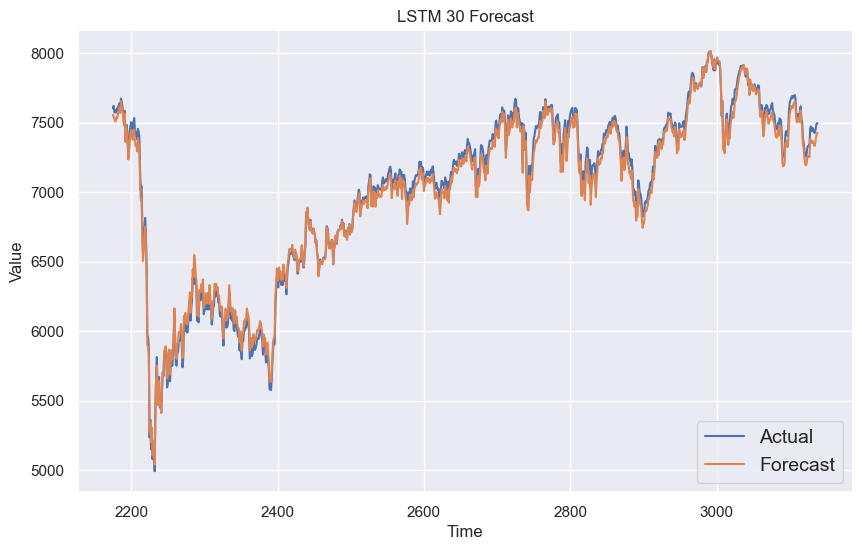

In [33]:
# plot results
plt.figure(figsize=(10,6))

plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.title(f'LSTM {window_size} Forecast')
plot_series(x_test.index, x_test, label="Actual")
plot_series(x_test.index, rnn_unscaled_forecast, label="Forecast")
plt.show()

In [34]:
# calculate MAE
keras.metrics.mean_absolute_error(x_test, rnn_unscaled_forecast).numpy()

48.517532